In [1]:
#Import Lib
import numpy as np
import pandas as pd 
from math import * # module math
import matplotlib.pyplot as plt 

#encode and scaling
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
#KNN
from sklearn.neighbors import KNeighborsClassifier
#Decision Tree

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, export_graphviz

import matplotlib.pyplot as plt # visualization
from PIL import Image
import seaborn as sns # visualization
import itertools
import io
import plotly.offline as py # visualization
py.init_notebook_mode(connected=True) # visualization
import plotly.graph_objs as go # visualization
from plotly.subplots import make_subplots
import plotly.figure_factory as ff # visualization


1. DATASET OVERVIEW & EXPLORATION

In [5]:
#Loaded Training and Test Sets
churn_train=pd.read_csv('churn_80.csv')
churn_test=pd.read_csv('churn_20.csv')
print(churn_train.head())
print('\n####\n',churn_test.head())

  State  Account length  Area code International plan Voice mail plan  \
0    KS             128        415                 No             Yes   
1    OH             107        415                 No             Yes   
2    NJ             137        415                 No              No   
3    OH              84        408                Yes              No   
4    OK              75        415                Yes              No   

   Number vmail messages  Total day minutes  Total day calls  \
0                     25              265.1              110   
1                     26              161.6              123   
2                      0              243.4              114   
3                      0              299.4               71   
4                      0              166.7              113   

   Total day charge  Total eve minutes  Total eve calls  Total eve charge  \
0             45.07              197.4               99             16.78   
1             27.47   

1.1. Statistical Description: Training Set

In [102]:
print(churn_train.describe())


       Account length    Area code  Number vmail messages  Total day minutes  \
count     2666.000000  2666.000000            2666.000000         2666.00000   
mean       100.620405   437.438860               8.021755          179.48162   
std         39.563974    42.521018              13.612277           54.21035   
min          1.000000   408.000000               0.000000            0.00000   
25%         73.000000   408.000000               0.000000          143.40000   
50%        100.000000   415.000000               0.000000          179.95000   
75%        127.000000   510.000000              19.000000          215.90000   
max        243.000000   510.000000              50.000000          350.80000   

       Total day calls  Total day charge  Total eve minutes  Total eve calls  \
count      2666.000000       2666.000000        2666.000000      2666.000000   
mean        100.310203         30.512404         200.386159       100.023631   
std          19.988162          9.21573

1.2. Summary of Dataset information: Training Set

In [6]:
print(churn_train.info())

# Print information about the churn_train dataframe
print("\n\nTraining Data Information")
print("-Rows               :", churn_train.shape[0])
print("-No. of Features    :", churn_train.shape[1])
print("-Features           :", churn_train.columns.tolist())
print("-No. of Null Values :", churn_train.isnull().sum().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      2666 non-null   

In [ ]:
1.3. Dataset Exploration

In [7]:
import plotly.graph_objs as go

churn_counts = churn_train['Churn'].value_counts()

fig = go.Figure(data=[go.Pie(
    labels=churn_counts.index,
    values=churn_counts.values,
    hole=0.5,
    marker=dict(colors=['#FF0000', '#d5d7ce'], line=dict(color='white', width=1.3)),
    rotation=90,
    hoverinfo='label+value+text'
)])

fig.update_layout(
    title="Customer churn in training data",
    plot_bgcolor="rgb(243,243,243)",
    paper_bgcolor="rgb(243,243,243)"
)

fig.show()


In [ ]:
2. Data Processing

2.1 Data Cleaning

**Take away correlated features

In [8]:
#Find a redundant features
bf_abs=churn_train.corr()
af_abs=bf_abs.abs()
print(af_abs)
#print('\n Mean Value per Each Features \n',af_abs.mean())

#REMOVING highly correlated features
col_to_drop = ['State', 'Area code', 'Total day charge', 'Total eve charge', 
               'Total night charge', 'Total intl charge']
   
churn_train = churn_train.drop(columns = col_to_drop, axis = 1)
churn_test = churn_test.drop(columns = col_to_drop, axis = 1)

#target column
target_col = ["Churn"]

print('\nCHURN_TRAIN', churn_train.head())
print('\n\n#CHURN_TEST', churn_test.head())

                        Account length  Area code  Number vmail messages  \
Account length                1.000000   0.008620               0.002996   
Area code                     0.008620   1.000000               0.000584   
Number vmail messages         0.002996   0.000584               1.000000   
Total day minutes             0.002847   0.023134               0.019027   
Total day calls               0.038862   0.009629               0.009622   
Total day charge              0.002843   0.023130               0.019027   
Total eve minutes             0.015923   0.000679               0.011401   
Total eve calls               0.018552   0.018602               0.005131   
Total eve charge              0.015909   0.000707               0.011418   
Total night minutes           0.008994   0.003353               0.000224   
Total night calls             0.024007   0.011455               0.008124   
Total night charge            0.008999   0.003382               0.000229   
Total intl m

 **Encode Categorical Data

In [9]:
#Separating categorical and numerical columns
#number of levels in feature to be a categorical feature
nlevels = 6
#categorical columns
cat_cols = list(set(churn_train.nunique()[churn_train.nunique()<nlevels].keys().tolist() 
                    + churn_train.select_dtypes(include='object').columns.tolist()))
cat_cols = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols = [x for x in churn_train.columns if x not in cat_cols + target_col]
print('\nNumeric Columns Check: ',num_cols)

#SPLITING COLUMN: Binary & Multi-value
#Binary columns with 2 values
binary_cols = churn_train.nunique()[churn_train.nunique() == 2].keys().tolist()
print('\n2-value Columns Check:',binary_cols)
#Mutli-value Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in binary_cols]
print('\n>2-value Columns Check:',multi_cols)

#2 METHODS to ENCODE
#ENCODING PROCESS by Label method for Binary columns on test& train data
le = LabelEncoder()
for i in binary_cols:
    churn_train[i] = le.fit_transform(churn_train[i])
    churn_test[i] = le.transform(churn_test[i])

#ENCODING PROCESS by get_dummies for multi-value columns
#combining the train and test datasets
trainsize = churn_train.shape[0]
combine = pd.concat((churn_train, churn_test), sort=False)

#Encode for multi value columns by get_dummies()
combine = pd.get_dummies(data = combine, columns = multi_cols)

#split the train and test datasets
churn_train= combine[:trainsize]
churn_test= combine[trainsize:]


print('\nCHURN_TRAIN', churn_train.head())
print('\n\n#CHURN_TEST', churn_test.head())



Numeric Columns Check:  ['Account length', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total eve minutes', 'Total eve calls', 'Total night minutes', 'Total night calls', 'Total intl minutes', 'Total intl calls', 'Customer service calls']

2-value Columns Check: ['International plan', 'Voice mail plan', 'Churn']

>2-value Columns Check: []

CHURN_TRAIN    Account length  International plan  Voice mail plan  Number vmail messages  \
0             128                   0                1                     25   
1             107                   0                1                     26   
2             137                   0                0                      0   
3              84                   1                0                      0   
4              75                   1                0                      0   

   Total day minutes  Total day calls  Total eve minutes  Total eve calls  \
0              265.1              110              197.4   

2.2 Data Transformation: Scaling Method

In [3]:
from sklearn.preprocessing import MinMaxScaler

# Scaling Numerical columns
# on Training Data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(churn_train[num_cols])
scaled = pd.DataFrame(scaled, columns=num_cols)

# on Testing Data
scaled_test = scaler.transform(churn_test[num_cols])
scaled_test = pd.DataFrame(scaled_test, columns=num_cols)

# dropping original---not scaled values---merging scaled values for numerical columns
# on Training Data
df_telcom_ogrin = churn_train.copy()
churn_train = churn_train.drop(columns=num_cols, axis=1)
churn_train = churn_train.merge(scaled, left_index=True, right_index=True, how="left")

# on Testing Data
df_telcom_test_og = churn_test.copy()
churn_test = churn_test.drop(columns=num_cols, axis=1)
churn_test = churn_test.merge(scaled_test, left_index=True, right_index=True, how="left")

print('\nCHURN_TRAIN', churn_train.head())
print('\n\n#CHURN_TEST', churn_test.head())


NameError: name 'churn_train' is not defined

2.3 Variable Summary after Preprocessing Stage

**Table Summary

In [10]:
import plotly.graph_objs as go
import plotly.offline as py

summary = churn_train.describe(include='all').transpose().reset_index()
summary = summary.rename(columns={"index": "feature"})

val_lst = [summary['feature'], summary['count'], summary['mean'], summary['std'],
           summary['min'], summary['25%'], summary['50%'], summary['75%'], summary['max']]

header = dict(values=summary.columns.tolist(),
              fill_color='#FF0000',
              align='left')
              
cells = dict(values=val_lst,
             fill_color='#d5d7ce',
             align='left')

table = go.Table(header=header, cells=cells)

layout = go.Layout(dict(title="Training variable Summary"))
figure = go.Figure(data=[table], layout=layout)

py.iplot(figure)


**Correlation Matrix

In [109]:
#correlation
correlation = churn_train.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array = np.array(correlation)

#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = [[0.0, '#FFFFFF'], [0.25, '#FEE5D9'], 
                                 [0.5, '#FCAE91'], [0.75, '#FB6A4A'], [1.0, '#DE2D26']],
                   colorbar = dict(title = " Correlation coefficients", titleside = "right"),
                  )
layout = go.Layout(dict(title = "Correlation matrix",
                        autosize = False,
                        height = 720,
                        width = 800,
                        margin = dict(r = 0, l = 210, t = 25, b = 210),
                        yaxis = dict(tickfont = dict(size = 9)),
                        xaxis = dict(tickfont = dict(size = 9))
                       )
                  )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

3. MODEL BUILLDING

DEFINE VARIABLES

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score

import statsmodels.api as sm

#defining the studied or used independent features (columns) as well the target  

target_col = ['Churn']
cols = [i for i in churn_train.columns if i not in target_col]

#SPLIT the principal training dataset into sub_train and sub_test datasets
x_train, x_test, y_train, y_test = train_test_split(churn_train[cols], churn_train[target_col], 
                                                    test_size = .20, random_state = 111)

#splitting the no scaled principal training dataset to subtrain and subtest datasets
#x_train_og, x_test_og, y_train_og, y_test_og = train_test_split(df_telcom_ogrin[cols], churn_train[target_col],
                                                                #test_size = .20, random_state = 111)

3.1. KNN

In [16]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

def telecom_churn_prediction(algorithm, training_x, testing_x, training_y, testing_y, cf, threshold_plot):
    #component naming
    algorithm.fit(training_x, training_y)
    predictions = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
        
    print('Algorithm:', type(algorithm).__name__)
    print("\nClassification report:\n", classification_report(testing_y, predictions))
    print("Accuracy Score:", accuracy_score(testing_y, predictions))

# Name the features (columns) and target
X = [i for i in churn_train.columns if i not in target_col]
y = ['Churn']

# splitting the principal training dataset to subtrain and subtest datasets
x_train, x_test, y_train, y_test = train_test_split(churn_train[X], churn_train[y], 
                                                    test_size = .20, random_state = 111)

# KNN MODELING
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
                           weights='uniform')
telecom_churn_prediction(knn, x_train, x_test, y_train, y_test, 'None', threshold_plot=True)



Algorithm: KNeighborsClassifier

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91       433
           1       0.73      0.24      0.36       101

    accuracy                           0.84       534
   macro avg       0.79      0.61      0.63       534
weighted avg       0.82      0.84      0.80       534

Accuracy Score: 0.8389513108614233


/Users/macos/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/macos/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



3.2 DECISION TREE

Algorithm: DecisionTreeClassifier

Classification report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95       433
           1       0.85      0.70      0.77       101

    accuracy                           0.92       534
   macro avg       0.89      0.84      0.86       534
weighted avg       0.92      0.92      0.92       534

Accuracy Score: 0.9194756554307116


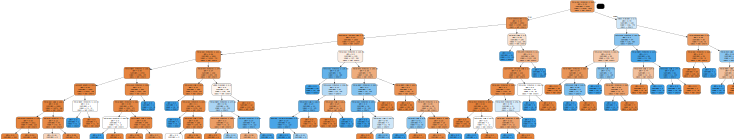

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from graphviz import Source
from IPython.display import SVG, display
import pydotplus

def treeplot(classifier, cols, classnames, output_path):
    #plot decision tree
    dot_data = tree.export_graphviz(classifier, out_file=None, 
                                    rounded=True, proportion=False,
                                    feature_names = cols, 
                                    precision = 2,
                                    class_names = classnames,
                                    filled = True,
                                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    graph.set_size('"10.2,7.7!"')
    return graph.create_svg()

decision_tree = DecisionTreeClassifier(max_depth = 8, random_state = 123,
                                       splitter = "best", criterion = "gini")

telecom_churn_prediction(decision_tree, x_train, x_test, y_train, y_test, "features", threshold_plot=True)

#plot decision tree and save it to a PNG file
tree_svg = treeplot(decision_tree, cols, ["Not churn", "Churn"], "tree.svg")

# Display the decision tree plot in the notebook
display(SVG(tree_svg))


3.3 Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

# Create a Logistic Regression object
logreg = LogisticRegression()

# Train the model on the training data
logreg.fit(x_train, y_train)

# Predict the target variable on the test data
y_pred = logreg.predict(x_test)

# Evaluate the model performance on the test data
print("\nLogistic Regression Model Evaluation:\n")
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Logistic Regression Model Evaluation:

Accuracy Score: 0.8146067415730337

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.99      0.90       433
           1       0.58      0.07      0.12       101

    accuracy                           0.81       534
   macro avg       0.70      0.53      0.51       534
weighted avg       0.78      0.81      0.75       534



/Users/macos/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/macos/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



4. EVALUATION MODELS

We use confusion matrice and ROC tools to evaluate three models. they are both performing on training and test set

4.1 Confusion Matrice & ROC On the Training Set

Defintion

In [27]:
#putting all the model names, model classes and the used columns in a dictionary
models = {'Decision Tree': [decision_tree, cols], 
          'KNN Classifier': [knn, cols], 
          'Logistic Regression': [logreg, cols], 
         }

#Define
def model_report(model, training_x, testing_x, training_y, testing_y, name):
    model = model.fit(training_x, training_y)
    predictions = model.predict(testing_x)
    accuracy = accuracy_score(testing_y, predictions)
    recallscore = recall_score(testing_y, predictions)
    precision = precision_score(testing_y, predictions)
    roc_auc = roc_auc_score(testing_y, predictions)
    f1score = f1_score(testing_y, predictions) 
    kappa_metric = cohen_kappa_score(testing_y, predictions)
    
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy"        : [accuracy],
                       "Recall"          : [recallscore],
                       "Precision"       : [precision],
                       "f1-score"        : [f1score],
                       "Roc_auc"         : [roc_auc],
                       "Kappa_metric"    : [kappa_metric],
                      })
    return df

Confusion Matrix Over Training Set

/Users/macos/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



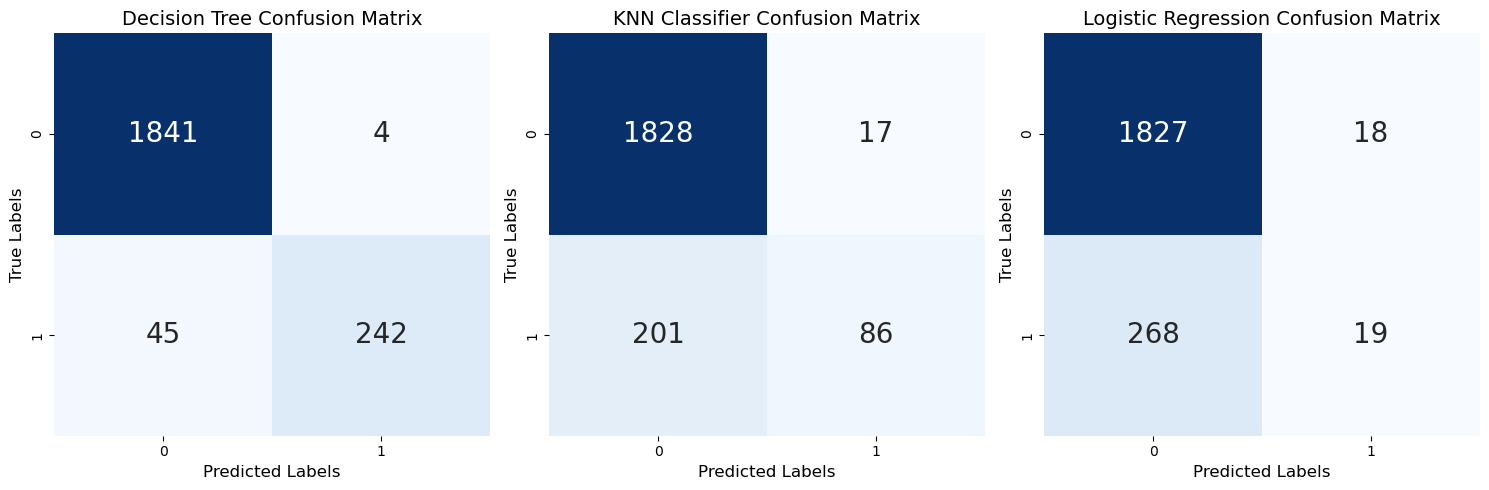

In [28]:
from sklearn.metrics import confusion_matrix

# Decision Tree Confusion Matrix
dt_y_pred = decision_tree.predict(x_train)
dt_cm = confusion_matrix(y_train, dt_y_pred)

# KNN Classifier Confusion Matrix
knn_y_pred = knn.predict(x_train)
knn_cm = confusion_matrix(y_train, knn_y_pred)

# Logistic Regression Confusion Matrix
nb_y_pred = logreg.predict(x_train)
nb_cm = confusion_matrix(y_train, nb_y_pred)

# Plot Confusion Matrices
plt.figure(figsize=(15, 5))

# Decision Tree
plt.subplot(1, 3, 1)
sns.heatmap(dt_cm, annot=True, cmap='Blues', fmt='g', cbar=False, annot_kws={"size": 20})
plt.title('Decision Tree Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)

# KNN Classifier
plt.subplot(1, 3, 2)
sns.heatmap(knn_cm, annot=True, cmap='Blues', fmt='g', cbar=False, annot_kws={"size": 20})
plt.title('KNN Classifier Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)

# Logistic Regression
plt.subplot(1, 3, 3)
sns.heatmap(nb_cm, annot=True, cmap='Blues', fmt='g', cbar=False, annot_kws={"size": 20})
plt.title('Logistic Regression Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
ROC on Training Set

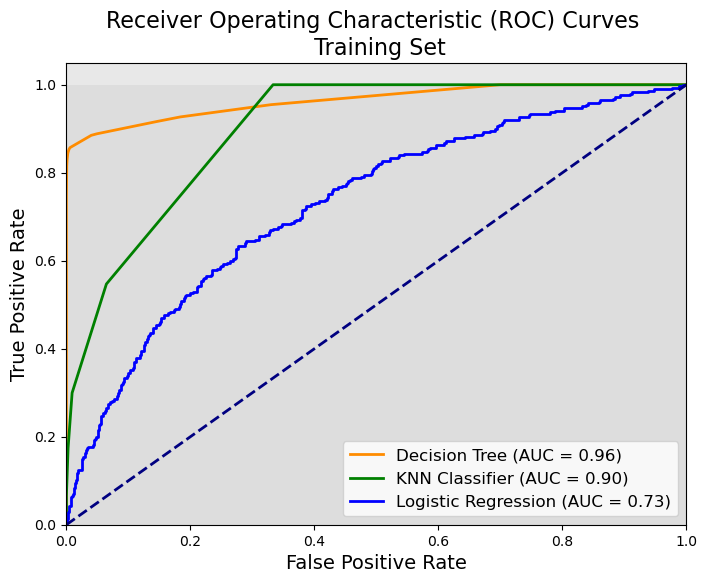

In [29]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Decision Tree ROC Curve
dt_fpr, dt_tpr, _ = roc_curve(y_train, decision_tree.predict_proba(x_train)[:,1])
dt_roc_auc = auc(dt_fpr, dt_tpr)

# KNN Classifier ROC Curve
knn_fpr, knn_tpr, _ = roc_curve(y_train, knn.predict_proba(x_train)[:,1])
knn_roc_auc = auc(knn_fpr, knn_tpr)

# Logistic Regression ROC Curve
nb_fpr, nb_tpr, _ = roc_curve(y_train, logreg.predict_proba(x_train)[:,1])
nb_roc_auc = auc(nb_fpr, nb_tpr)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.axhspan(0, 1, facecolor='lightgray', alpha=0.5) # add gray background
plt.axvspan(0, 1, facecolor='lightgray', alpha=0.5) # add gray background
plt.plot(dt_fpr, dt_tpr, color='darkorange', lw=2, label='Decision Tree (AUC = %0.2f)' % dt_roc_auc)
plt.plot(knn_fpr, knn_tpr, color='green', lw=2, label='KNN Classifier (AUC = %0.2f)' % knn_roc_auc)
plt.plot(nb_fpr, nb_tpr, color='blue', lw=2, label='Logistic Regression (AUC = %0.2f)' % nb_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curves \n Training Set', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()



4.2. Confusion Matrix and ROC On Test Set

Confusion Matrice over Test Set


/Users/macos/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



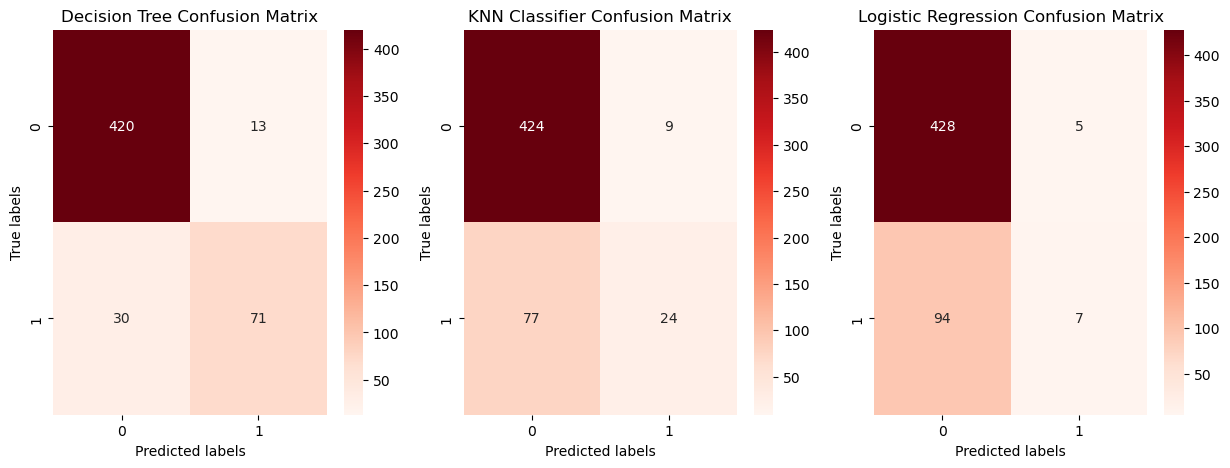

In [22]:
from sklearn.metrics import confusion_matrix

# Decision Tree Confusion Matrix
y_pred_dt = decision_tree.predict(x_test)
cm_dt = confusion_matrix(y_test, y_pred_dt)

# KNN Classifier Confusion Matrix
y_pred_knn = knn.predict(x_test)
cm_knn = confusion_matrix(y_test, y_pred_knn)

# Logistic Regression Confusion Matrix
y_pred_nb = logreg.predict(x_test)
cm_nb = confusion_matrix(y_test, y_pred_nb)

# Plot the confusion matrices
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].set_title('Decision Tree Confusion Matrix')
sns.heatmap(cm_dt, annot=True, cmap='Reds', fmt='g', ax=axs[0])
axs[0].set_xlabel('Predicted labels')
axs[0].set_ylabel('True labels')
axs[1].set_title('KNN Classifier Confusion Matrix')
sns.heatmap(cm_knn, annot=True, cmap='Reds', fmt='g', ax=axs[1])
axs[1].set_xlabel('Predicted labels')
axs[1].set_ylabel('True labels')
axs[2].set_title('Logistic Regression Confusion Matrix')
sns.heatmap(cm_nb, annot=True, cmap='Reds', fmt='g', ax=axs[2])
axs[2].set_xlabel('Predicted labels')
axs[2].set_ylabel('True labels')

plt.show()

ROC over Test Set

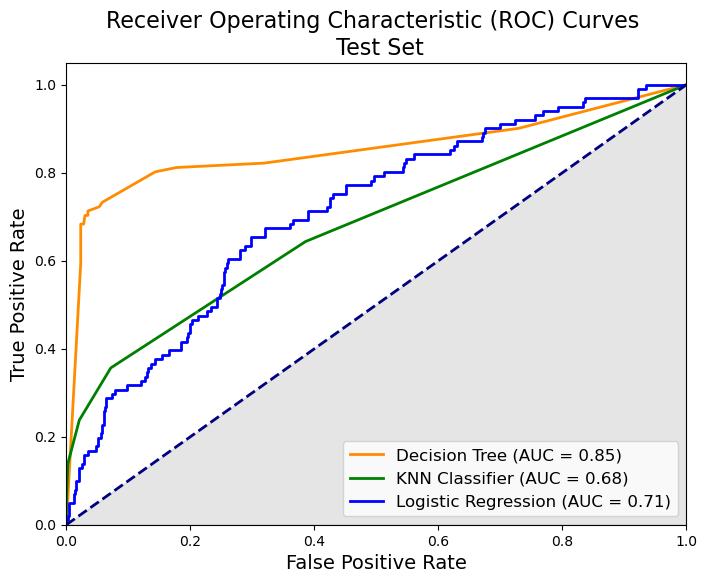

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Decision Tree ROC Curve
dt_fpr, dt_tpr, _ = roc_curve(y_test, decision_tree.predict_proba(x_test)[:,1])
dt_roc_auc = auc(dt_fpr, dt_tpr)

# KNN Classifier ROC Curve
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn.predict_proba(x_test)[:,1])
knn_roc_auc = auc(knn_fpr, knn_tpr)

# Logistic Regression ROC Curve
nb_fpr, nb_tpr, _ = roc_curve(y_test, logreg.predict_proba(x_test)[:,1])
nb_roc_auc = auc(nb_fpr, nb_tpr)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(dt_fpr, dt_tpr, color='darkorange', lw=2, label='Decision Tree (AUC = %0.2f)' % dt_roc_auc)
plt.plot(knn_fpr, knn_tpr, color='green', lw=2, label='KNN Classifier (AUC = %0.2f)' % knn_roc_auc)
plt.plot(nb_fpr, nb_tpr, color='blue', lw=2, label='Logistic Regression (AUC = %0.2f)' % nb_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curves \n Test Set', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.fill_between([0,1], [0,1], color='gray', alpha=0.2) # Add gray background
plt.show()

5. COMPARISION on Both Training and Test Set

In [30]:
model_performances_train = pd.DataFrame() 
for name in models:
    if name == 'Logistic (SMOTE)':
        model_performances_train = model_performances_train.append(model_report(models[name][0], x_smote[models[name][1]], 
                                                     x_test[models[name][1]], 
                                                     y_smote, y_test, name), ignore_index=True)
    else:
        model_performances_train = model_performances_train.append(model_report(models[name][0], 
                                                     x_train[models[name][1]], 
                                                     x_test[models[name][1]], 
                                                     y_train, y_test, name), ignore_index=True)
colorscale = [[0, '#1a2a0d'], [1, '#d5d7ce']]
table_train = ff.create_table(np.round(model_performances_train, 4),
                              colorscale=colorscale)
py.iplot(table_train)


/var/folders/q4/599_9y312tq2r68dy826djjr0000gn/T/ipykernel_55546/919247374.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/macos/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/macos/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

/var/folders/q4/599

In [121]:
import plotly.graph_objs as go


# Define colors for each trace
colors = ['#400005', '#FF0000', '#f95462', '#d5d7ce', '#FFC0CB', '#c54f6b']

# Define data for the bar chart
metrics = ['Accuracy', 'Recall', 'Precision', 'f1-score', 'Roc_auc', 'Kappa_metric']
traces = []
for i, metric in enumerate(metrics):
    trace = go.Bar(
        x=model_performances_train[metric],
        y=model_performances_train.Model,
        orientation='h',
        marker=dict(color=colors[i], opacity=0.8),
        name=metric,
        text=model_performances_train[metric],
        textposition='auto'
    )
    traces.append(trace)

# Define layout
layout = go.Layout(
    barmode='group',
    title='Model Metrics Performance over Training Set',
    yaxis=dict(autorange="reversed"),
    margin=dict(l=150),
)

# Create and show the figure
fig = go.Figure(data=traces, layout=layout)
py.iplot(fig)


Over Test Set

In [31]:
model_performances_test = pd.DataFrame() 
for name in models:
    if name == 'Logistic (SMOTE)':
        model_performances_test = model_performances_test.append(model_report(models[name][0],
                                                    x_smote[models[name][1]], churn_test[models[name][1]],
                                                    y_smote, churn_test[target_col], name), ignore_index=True)
    else:
        model_performances_test = model_performances_test.append(model_report(models[name][0],
                                                    x_train[models[name][1]], churn_test[models[name][1]], 
                                                    y_train, churn_test[target_col], name), ignore_index=True)
colorscale = [[0, '#8B0000'], [1, '#FFC0CB']]  



table_test = ff.create_table(np.round(model_performances_test, 4), colorscale=colorscale)
py.iplot(table_test)

/var/folders/q4/599_9y312tq2r68dy826djjr0000gn/T/ipykernel_55546/2083181859.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/macos/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/macos/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

/var/folders/q4/59

In [26]:
# Define colors for each trace
colors = ['#400005', '#FF0000', '#f95462', '#d5d7ce', '#FFC0CB', '#c54f6b']

# Define data for the bar chart
traces = [go.Bar(x=model_performances_test[column],
                 y=model_performances_test.Model,
                 orientation='h',
                 marker=dict(color=colors[i], opacity=0.8),
                 name=column,
                 text=model_performances_test[column],
                 textposition='auto') for i, column in enumerate(['Accuracy', 
                                                                  'Recall', 'Precision', 
                                                                  'f1-score', 'Roc_auc', 'Kappa_metric'])]

# Define layout
layout = go.Layout(
    barmode='group',
    title='Model Metrics Performance over Test Set',
    yaxis=dict(autorange="reversed"),
    margin=dict(l=150),
)

# Create and show the figure
fig = go.Figure(data=traces, layout=layout)
py.iplot(fig)